# Training a Boltzmann Generator for Alanine Dipeptide

This notebook introduces basic concepts behind `bgflow`. 

It shows how to build an train a Boltzmann generator for a small peptide. The most important aspects it will cover are

- retrieval of molecular training data
- defining a internal coordinate transform
- defining normalizing flow classes
- combining different normalizing flows
- training a Boltzmann generator via NLL and KLL

The main purpose of this tutorial is to introduce the implementation. The network design is optimized for educational purposes rather than good performance. In the conlusions, we will discuss some aspects of the generator that are not ideal and outline improvements.

## Some Preliminaries

We instruct jupyter to reload any imports automatically and define the device and datatype, on which we want to perform the computations.

In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

In [12]:
import torch

device = "cuda:3" if torch.cuda.is_available() else "cpu"
dtype = torch.float32

# a context tensor to send data to the right device and dtype via '.to(ctx)'
ctx = torch.zeros([], device=device, dtype=dtype)

# a brief check if this module is the main executable (or imported)
main = (__name__ == "__main__")



## Load the Data and the Molecular System

Molecular trajectories and their corresponding potential energy functions are available from the `bgmol` repository.

import os
from bgmol.datasets import Ala2TSF300

is_data_here = os.path.isfile("Ala2TSF300.npy")
datasetf = Ala2TSF300(download=(not is_data_here), read=True)
systemf = datasetf.system
coordinatesf = datasetf.coordinates
temperaturef = datasetf.temperature
dimf = datasetf.dim

In [13]:
import os
import mdtraj
#dataset = mdtraj.load('output.dcd', top='ala2_fromURL.pdb')
rough_dataset = mdtraj.load('proline_trajectory.dcd', top='Pro.pdb')
dataset = rough_dataset.superpose(rough_dataset[0])
fname = "pro"

coordinates = dataset.xyz
n_atoms = 17

from simtk import unit
temperature = 300.0 * unit.kelvin
collision_rate = 1.0 / unit.picosecond
timestep = 4.0 * unit.femtosecond

In [5]:
# from bgmol.datasets import Ala2TSF300
# target_energy = Ala2TSF300().get_energy_model(n_workers=1)

In [14]:
n_iter_NLL = 20000
n_iter_mixed = 2000

In [15]:
import numpy as np
rigid_block = np.array([4,2,1])
z_matrix = np.array([
    [0, 1, 2, 4],
    [3, 2, 1, 0],
    [5, 4, 2, 1],
    [6, 2, 1, 0],
    [7, 6, 2, 1],
    [8, 6, 2, 1],
    [9, 0, 1, 2],
    [10, 0, 1, 2],
    [11, 1, 2, 4],
    [12, 1, 2, 4],
    [13, 4, 2, 1],
    [14, 5, 4, 2],
    [15, 5, 4, 2],
    [16, 8, 6, 2]
])

In [16]:

def dimensions(dataset):
        return np.prod(dataset.xyz[0].shape)
dim = dimensions(dataset)
print(dim)


51


In [17]:
from simtk import openmm
with open('proline_xmlsystem.txt') as f:
    xml = f.read()
system = openmm.XmlSerializer.deserialize(xml)

from bgflow.distribution.energy.openmm import OpenMMBridge, OpenMMEnergy
from openmmtools import integrators

integrator = integrators.LangevinIntegrator(temperature=temperature,collision_rate=collision_rate,timestep=timestep)

energy_bridge = OpenMMBridge(system, integrator, n_workers=1)
target_energy = OpenMMEnergy(int(dim), energy_bridge)

The energy model is a `bgflow.Energy` that wraps around OpenMM. The `n_workers` argument determines the number of openmm contexts that are used for energy evaluations. In notebooks, we set `n_workers=1` to avoid hickups. In production, we can omit this argument so that `n_workers` is automatically set to the number of CPU cores.

In [26]:
import mdtraj as md 
#trajectory = md.Trajectory(xyz=dataset.cpu().detach().numpy().reshape(-1, n_atoms, 3), topology=md.load('Pro.pdb').topology)

top = md.load('Pro.pdb').topology

for atom in top.atoms:
    print(atom, atom.index)

PRO1-CG 0
PRO1-CB 1
PRO1-CA 2
PRO1-HA 3
PRO1-N 4
PRO1-CD 5
PRO1-C 6
PRO1-O 7
PRO1-OXT 8
PRO1-HG3 9
PRO1-HG2 10
PRO1-HB3 11
PRO1-HB2 12
PRO1-H 13
PRO1-HD3 14
PRO1-HD2 15
PRO1-HXT 16


### Visualize Data: Ramachandran Plot for the Backbone Angles

In [27]:
def compute_phi_psi(trajectory):
    phi_atoms = [6, 2, 4,13]
    phi = md.compute_dihedrals(trajectory, indices=[phi_atoms])[:, 0]
    psi_atoms = [4, 2, 6, 8]
    psi = md.compute_dihedrals(trajectory, indices=[psi_atoms])[:, 0]
    return phi, psi

In [28]:
import numpy as np
import mdtraj as md 
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

def plot_phi_psi(ax, trajectory):
    if not isinstance(trajectory, md.Trajectory):
        trajectory = md.Trajectory(
            xyz=trajectory.cpu().detach().numpy().reshape(-1, n_atoms, 3), 
            topology=md.load('Pro.pdb').topology
        )
    phi, psi = compute_phi_psi(trajectory)
    
    ax.hist2d(phi, psi, 50, norm=LogNorm())
    ax.set_xlim(-np.pi, np.pi)
    ax.set_ylim(-np.pi, np.pi)
    ax.set_xlabel("$\phi$")
    _ = ax.set_ylabel("$\psi$")
    
    return trajectory

In [12]:
#print(dataset.trajectory[:])

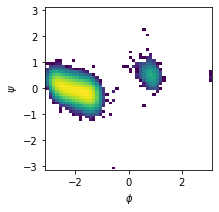

In [29]:
if main:
    fig, ax = plt.subplots(figsize=(3,3))
    trajectory_md = plot_phi_psi(ax, dataset)
    #trajectory_md.save("TSFtraj.dcd")
    #plt.savefig(f'varysnapshots/Ramachandran{fname}.png',bbox_inches='tight')

## Split Data and Randomly Permute Samples

In [30]:
n_train = len(dataset)//2
n_test = len(dataset) - n_train
permutation = np.random.permutation(n_train)

all_data = coordinates.reshape(-1, dimensions(dataset))
training_data = torch.tensor(all_data[permutation]).to(ctx)
test_data = torch.tensor(all_data[permutation + n_train]).to(ctx)

## Define the Internal Coordinate Transform

Rather than generating all-Cartesian coordinates, we use a mixed internal coordinate transform.
The five central alanine atoms will serve as a Cartesian "anchor", from which all other atoms are placed with respect to internal coordinates (IC) defined through a z-matrix. We have deposited a valid `z_matrix` and the corresponding `rigid_block` in the `dataset.system` from `bgmol`.

In [31]:
import bgflow as bg

In [32]:
# throw away 6 degrees of freedom (rotation and translation)
dim_cartesian = len(rigid_block) * 3 - 6
print(dim_cartesian)
#dim_cartesian = len(system.rigid_block) * 3
dim_bonds = len(z_matrix)
print(dim_bonds)
dim_angles = dim_bonds
dim_torsions = dim_bonds

3
14


In [33]:
coordinate_transform = bg.MixedCoordinateTransformation(
    data=training_data, 
    z_matrix=z_matrix,
    fixed_atoms=rigid_block,
    #keepdims=None,
    keepdims=dim_cartesian, 
    normalize_angles=True,
).to(ctx)

For demonstration, we transform the first 3 samples from the training data set into internal coordinates as follows:

In [34]:
bonds, angles, torsions, cartesian, dlogp = coordinate_transform.forward(training_data[:3])
bonds.shape, angles.shape, torsions.shape, cartesian.shape, dlogp.shape
#print(bonds)

(torch.Size([3, 14]),
 torch.Size([3, 14]),
 torch.Size([3, 14]),
 torch.Size([3, 3]),
 torch.Size([3, 1]))

## Prior Distribution

The next step is to define a prior distribution that we can easily sample from. The normalizing flow will be trained to transform such latent samples into molecular coordinates. Here, we just take a normal distribution, which is a rather naive choice for reasons that will be discussed in other notebooks.

In [35]:
dim_ics = dim_bonds + dim_angles + dim_torsions + dim_cartesian
mean = torch.zeros(dim_ics).to(ctx) 
# passing the mean explicitly to create samples on the correct device
prior = bg.NormalDistribution(dim_ics, mean=mean)

## Normalizing Flow

Next, we set up the normalizing flow by stacking together different neural networks. For now, we will do this in a rather naive way, not distinguishing between bonds, angles, and torsions. Therefore, we will first define a flow that splits the output from the prior into the different IC terms.

### Split Layer

In [36]:
split_into_ics_flow = bg.SplitFlow(dim_bonds, dim_angles, dim_torsions, dim_cartesian)

In [37]:
# test
#print(prior.sample(3))
_ics = split_into_ics_flow(prior.sample(1))
#print(_ics)
coordinate_transform.forward(*_ics, inverse=True)[0].shape

torch.Size([1, 51])

### Coupling Layers

Next, we will set up so-called RealNVP coupling layers, which split the input into two channels and then learn affine transformations of channel 1 conditioned on channel 2. Here we will do the split naively between the first and second half of the degrees of freedom.

In [38]:
class RealNVP(bg.SequentialFlow):
    
    def __init__(self, dim, hidden):
        self.dim = dim
        self.hidden = hidden
        super().__init__(self._create_layers())
    
    def _create_layers(self):
        dim_channel1 =  self.dim//2
        dim_channel2 = self.dim - dim_channel1
        split_into_2 = bg.SplitFlow(dim_channel1, dim_channel2)
        
        layers = [
            # -- split
            split_into_2,
            # --transform
            self._coupling_block(dim_channel1, dim_channel2),
            bg.SwapFlow(),
            self._coupling_block(dim_channel2, dim_channel1),
            # -- merge
            bg.InverseFlow(split_into_2)
        ]
        return layers
        
    def _dense_net(self, dim1, dim2):
        return bg.DenseNet(
            [dim1, *self.hidden, dim2],
            activation=torch.nn.ReLU()
        )
    
    def _coupling_block(self, dim1, dim2):
        return bg.CouplingFlow(bg.AffineTransformer(
            shift_transformation=self._dense_net(dim1, dim2),
            scale_transformation=self._dense_net(dim1, dim2)
        ))
    

In [39]:
RealNVP(dim_ics, hidden=[128]).to(ctx).forward(prior.sample(3))[0].shape

torch.Size([3, 45])

### Boltzmann Generator

Finally, we define the Boltzmann generator.
It will sample molecular conformations by 

1. sampling in latent space from the normal prior distribution,
2. transforming the samples into a more complication distribution through a number of RealNVP blocks (the parameters of these blocks will be subject to optimization),
3. splitting the output of the network into blocks that define the internal coordinates, and
4. transforming the internal coordinates into Cartesian coordinates through the inverse IC transform.

In [40]:
n_realnvp_blocks = 5
layers = []

for i in range(n_realnvp_blocks):
    layers.append(RealNVP(dim_ics, hidden=[128, 128, 128]))
layers.append(split_into_ics_flow)
layers.append(bg.InverseFlow(coordinate_transform))

flow = bg.SequentialFlow(layers).to(ctx)

In [45]:
# test
print(flow.forward(prior.sample(6)))

flow.forward(training_data[:3], inverse=True)

(tensor([[-2.9588e-01, -3.0112e-01,  3.3156e-01, -5.5527e-02, -1.5621e-02,
          9.8311e-02,  3.5732e-02,  7.6661e-02,  1.5044e-02, -2.4132e-01,
         -7.4483e-01, -2.0101e-02,  9.0127e-02,  1.7318e-01,  1.1331e-01,
          3.5903e-01,  6.6803e-01, -2.6515e-02, -3.9665e-03, -9.8776e-02,
          2.4710e-01, -1.9043e-01, -9.7119e-01,  1.3902e+00, -5.9547e-02,
         -2.2508e-01,  4.5752e-01, -1.2197e-01, -5.7881e-01,  7.7325e-01,
         -1.2044e+00,  7.2827e-01, -1.0998e+00, -9.8662e-02,  1.6627e-01,
         -3.8522e-02,  9.1328e-02, -3.2059e-01,  5.3236e-02,  7.2323e-01,
          9.7710e-01,  1.3165e+00,  6.2587e-01,  1.5108e+00,  1.7953e-01,
          1.7901e-01,  1.1902e+00,  2.2973e-01, -1.3703e-01,  2.6556e-01,
          4.5314e-01],
        [-1.4922e-01, -5.6475e-03,  9.1711e-02, -7.4876e-02,  6.6895e-03,
          9.6968e-02,  3.6698e-02,  7.1289e-02,  1.6646e-02, -1.1839e+00,
         -5.4355e-01, -3.8866e-01,  1.0119e-01,  1.6319e-01,  1.1356e-01,
          1.85

RuntimeError: mat1 and mat2 shapes cannot be multiplied (3x22 and 23x128)

In [28]:
# print number of trainable parameters
"#Parameters:", np.sum([np.prod(p.size()) for p in flow.parameters()])

('#Parameters:', 778700)

In [47]:
generator = bg.BoltzmannGenerator(
    flow=flow,
    prior=prior,
    target=target_energy
)

In [30]:
def plot_energies(ax, samples, target_energy, test_data):
    sample_energies = target_energy.energy(samples).cpu().detach().numpy()
    md_energies = target_energy.energy(test_data[:len(samples)]).cpu().detach().numpy()
    cut = max(np.percentile(sample_energies, 80), 20)
    
    ax.set_xlabel("Energy   [$k_B T$]")
    # y-axis on the right
    ax2 = plt.twinx(ax)
    ax.get_yaxis().set_visible(False)
    
    ax2.hist(sample_energies, range=(-50, cut), bins=40, density=False, label="BG")
    ax2.hist(md_energies, range=(-50, cut), bins=40, density=False, label="MD")
    ax2.set_ylabel(f"Count   [#Samples / {len(samples)}]")
    ax2.legend()

## Train

Boltzmann generators can be trained in two ways:
1. by matching the density of samples from the training data via the negative log likelihood (NLL), and
2. by matching the target density via the backward Kullback-Leibler loss (KLL).

NLL-based training is faster, as it does not require the computation of molecular target energies. Therefore, we will first train the generator solely by density estimation.

### NLL Training

In [31]:
nll_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-3)
nll_trainer = bg.KLTrainer(
    generator, 
    optim=nll_optimizer,
    train_energy=False
)

In [32]:

nll_trainer.train(
    n_iter=n_iter_NLL, 
    data=training_data,
    batchsize=128,
    n_print=1000, 
    w_energy=0.0
)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (128x22 and 23x128)

To see what the generator has learned so far, let's first create a bunch of samples and compare their backbone angles with the molecular dynamics data. Let's also plot their energies.

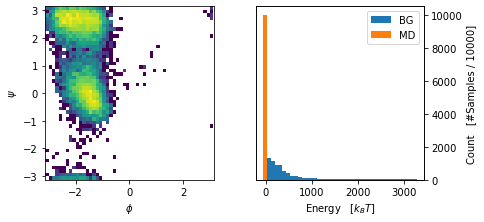

In [31]:
if main:
    
    n_samples = 10000
    samples = generator.sample(n_samples)

    fig, axes = plt.subplots(1, 2, figsize=(6,3))
    fig.tight_layout()

    plot_phi_psi(axes[0], samples)
    plot_energies(axes[1], samples, target_energy, test_data)
    #plt.savefig("NLL_learnt.png")

    del samples

### Mixed Training

The next step is "mixed" training with a combination of NLL and KLL. To retain some of the progress made in the NLL phase, we decrease the learning rate and increase the batch size.

In [48]:
mixed_optimizer = torch.optim.Adam(generator.parameters(), lr=1e-4)
mixed_trainer = bg.KLTrainer(
    generator, 
    optim=mixed_optimizer,
    train_energy=True
)

Mixed training will be considerably slower. 
To speed it up, you can change the settings for the OpenMM energy when creating the energy model. For example, consider not passing `n_workers=1`.

To avoid large potential energy gradients from singularities, the components of the KL gradient are constrained to (-100, 100). 

In [51]:

mixed_trainer.train(
    n_iter=n_iter_mixed, 
    data=training_data,
    batchsize=1000,
    n_print=100, 
    w_energy=0.1,
    w_likelihood=0.9,
    clip_forces=20.0
    )

RuntimeError: mat1 and mat2 shapes cannot be multiplied (1000x22 and 23x128)

Plot the results:

In [34]:
torch.save(flow.state_dict(),f'model{fname}.pt')
#torch.save(generator.state_dict(keep_vars=True),f'model{fname}.pt')

tensor([[ 0.3505,  2.1982,  0.2313,  ...,  0.3659,  2.8786,  0.3817],
        [ 0.3565,  2.0424,  0.2199,  ...,  0.3540,  2.6434,  0.3011],
        [ 0.1403,  1.9529,  0.1592,  ..., -0.2955,  2.8608,  0.4830],
        ...,
        [ 0.3268,  2.0293,  0.2778,  ...,  0.3150,  3.2134,  0.2782],
        [ 0.3647,  2.1527,  0.2907,  ..., -0.3813,  2.9547, -0.0518],
        [ 0.2286,  2.0371,  0.1541,  ...,  0.2092,  2.7980,  0.3208]],
       device='cuda:1', grad_fn=<ViewBackward>)


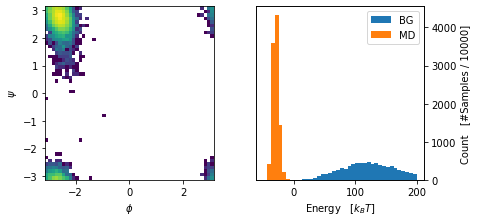

In [35]:
n_samples = 10000
samples = generator.sample(n_samples)
print(samples)

fig, axes = plt.subplots(1, 2, figsize=(6,3))
fig.tight_layout()

samplestrajectory = plot_phi_psi(axes[0], samples)
plot_energies(axes[1], samples, target_energy, test_data)
plt.savefig(f"varysnapshots/{fname}.png", bbox_inches = 'tight')

#samplestrajectory.save("samplestraj.dcd")

#del samples

With nglview installed, we can also take a look at the samples.

In [36]:
import nglview as nv

#samplestrajectory = mdtraj.Trajectory(
#    xyz=samples.cpu().detach().numpy().reshape(-1, 22, 3),
#    topology="ala2_fromURL.pdb")

samplestrajectory.save(f"{fname}_samplestraj.dcd")
#mdtraj.save(samplestrajectory, "obcstride10Samplestraj.dcd")

widget = nv.show_mdtraj(samplestrajectory)

widget

NGLWidget(max_frame=9999)

## Conclusions

This tutorial has introduced the most basic concepts and implementations underlying Boltzmann generators and `bgflow`. That said, the trained networks did not do a particularly good job in reproducing the molecular Boltzmann distribution. Specifically, they only modeled the major modes of the $\phi$ angle and still produced many samples with unreasonably large energies. Let's look at a few shortcomings of the present architecture:

### 1) Unconstrained Internal Coordinates
Bonds, angles, and torsions must not take arbitrary values in principle. Bond lengths need to be positive, angles live in $[0,\pi],$ and torsions are periodic in $[-\pi, \pi].$ Neither those bounds nor the periodicity of torsions distributions have been taken into account by the present Boltzmann generator. The layers of the normalizing flow should be build in a way that preserves these constraints on the ICs.

### 2)  Arbitrary Coupling
The input for the coupling layers was split into two channels rather arbitrarily (first vs. second half). A partial remedy is to define the conditioning in a physically informed manner. Another solution is to augment the base space by momenta, which can be done with augmented normalizing flows (see for instance the notebook on temperature-steering flows).

### 3) RealNVP Layers
Affine coupling layers are well-known to perform poorly in separating modes. This explains that the metastable region around $\phi \approx \pi/2$ was not captured by the generator. Other architectures such as augmented flows or neural spline flows do a better job for complicated, multimodal distributions.

### 4) Training
The generators were only trained for relatively few iterations and performance may improve with longer training and better choices of the learning rate and hyperparameters.